In [1]:
%matplotlib inline

import numpy as np;
import time;
import numba as jit;
from numba import autojit
from copy import deepcopy;
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
from IPython import display
import matplotlib.animation as manimation
import gc;
import winsound;

C:\Users\sybre\Anaconda3\lib\site-packages\matplotlib\__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


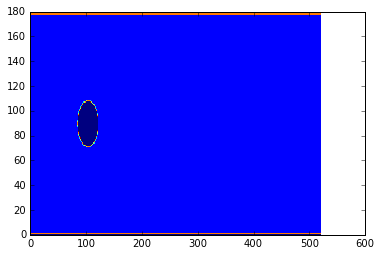

In [36]:
# GRID

#           4    3    2
#
#           5    0    1
#
#           6    7    8

# Define variables used
directions               = 9;            # We use a D2Q9 system here which is a rectangular grid
grid_size_x              = 520;          # 520 nodes in the x-direciton
grid_size_y              = 180;          # 180 nodes in the y-direction
speed_of_sound           = 1;            # Everything is scaled to LB units
time_step                = 1 / speed_of_sound;   # To keep the system stable the timestep must be this.
directional_weights      = np.array([16,4,1,4,1,4,1,4,1]) / 36;       
unit_x_velocities        = np.array([0, 1, 1, 0, -1, -1, -1, 0, 1]);
unit_y_velocities        = np.array([0, 0, 1, 1, 1, 0, -1, -1, -1]);
ei                       = np.stack((unit_x_velocities, unit_y_velocities));
oppositeDirection        = np.array([0, 5, 6, 7, 8, 1, 2, 3, 4]);     # These are the opposites of the index directions
Reynolds                 = 220;          # Reynolds number which we want to simulate
inlet_velocity           = 0.04;         # Velocity at the inlet. Larger then 1 causes instabilities. Lower then 0.1 is advised.
relaxation_constant      = 3 * (inlet_velocity * 20 / Reynolds) + 0.5;     # This relaxation constant is related to viscosity in normal units.

# Create the grid. We use a triangular grid
x          = np.linspace(0, 1, grid_size_x);
y          = np.linspace(0, 1, grid_size_y);
[X, Y]     = np.meshgrid(x,y);                     # This is a rectangular grid

# Create the velocity grid.
u           = np.ones(np.shape(x)) * inlet_velocity;
v           = np.zeros(np.shape(y));
[U, V]      = np.meshgrid(u,v);
U = np.dstack((U,V));           # U and V are placed in the same matrix to make good use of inner products later.

# Place walls at the top and bottom
Active = np.ones(X.shape);
Active[[0,-1],:] = 0; # Top and bottom boundary

# Place a sphere at location 0.2,0.5 with r = 0.1
for i in range(Active.shape[0]):
    for j in range(Active.shape[1]):
        if ((X[i,j] - 0.2)**2 * (grid_size_x / grid_size_y)**2  + (Y[i,j] - 0.5)**2 < 0.01):
            Active[i,j] = 0;

# Calculate the boundary elements
Boundary = np.zeros(X.shape);
for i in range(1,9):
    Boundary = Boundary + np.roll(np.roll(Active, ei[0,i], axis=1), ei[1,i], axis=0);

# All locations which are smaller than 8 and active are a boundary
Boundary = ((8 - Boundary) * Active > 0) * (8 - Boundary);
BoundaryList = np.zeros([np.int(np.sum(Boundary)),4]);
BoundaryPositions = np.nonzero(Active==0);
BoundaryPositions = np.tile(BoundaryPositions, 9);
#BoundaryPositions = np.swapaxes(BoundaryPositions, 2,0)

# This array is used later to replace velocity distributions at the boundary
Arr = np.tile(np.arange(9), (np.int(BoundaryPositions.shape[1]/9),1))
Arr = np.reshape(Arr, Arr.size,1);

# Here we give an indication of the flow field
plt.pcolor(Boundary * 2 + Active);

In [3]:
# Because these terms are too long in the formulas, I use abbreviations
C = speed_of_sound;
tau = relaxation_constant;

# Initialize the velocity distributions
f_prev = np.zeros((Active.shape[0], Active.shape[1], directions))
f_next = np.zeros((Active.shape[0], Active.shape[1], directions))
f_eq   = np.zeros((Active.shape[0], Active.shape[1], directions))

# Create an initial state which should help to get things stabilized quickly
rho = np.ones(Active.shape);
a = np.dot(U,ei);
b = np.power(a,2);
c = np.power(U[:,:,0],2) + np.power(U[:,:,1],2);
for i in range(0,directions):
    f_prev[:,:,i] = directional_weights[i] * rho * (
        1 + 
        6 / 2 * a[:,:,i] * C ** -2 + 
        9 / 2 * b[:,:,i] * C ** -4 -
        3 / 2 * c[:,:] * C ** -2
    );
f_next[BoundaryPositions[0,:], BoundaryPositions[1,:], Arr] = 0;

# Initial time is set to 0
t = 0;

In [34]:
# If we want to save the flow file dat any time, this function will save it as a .png image.
# It does havea small memory leak so shouldn't be called too often.
def save_image(X,Y,U,rho):
    fig = plt.figure(num=None, figsize=(15,3), dpi=300);
    axes = plt.gca()
    axes.set_xlim([0,1])
    axes.set_ylim([0,1])
    res = 1;
    plt.pcolor(X[0:-1:res, 0:-1:res], Y[0:-1:res, 0:-1:res], rho[0:-1:res, 0:-1:res], vmin=0.94, vmax=1.06);
    a = 5;
    b = 10;
    plt.colorbar();        
    plt.quiver(X[::a,::b],Y[::a,::b],U[::a,::b,0],U[::a,::b,1]);
    plt.savefig('images/image'+str(t)+'.png');
    axes.cla();
    fig.clf();
    plt.clf();
    plt.close();

In [37]:
time_steps = 5000;  # How many time steps we want to simulate at once

start_time = time.clock();

# If we already finished a previous simulations, this allows us to continue with the data.
ct = t;
for t in range(ct, ct + time_steps):
    # Reset to a zero distribution.
    f_next[:,:,:] = 0;

    # Outflow condition
    f_prev[:,-1,:] = f_prev[:,-2,:]

    # Calculate the used field
    rho = np.sum(f_prev, axis=2);
    has_rho = np.logical_and(Active==1,rho>0);
    U[:,:,:] = 0;
    U[has_rho,::] = np.divide(
        np.dot(f_prev, np.transpose(ei))[has_rho,:] ,
        rho[has_rho,np.newaxis]
    );
    
    # Inlet condition
    U[:,0,0] = np.ones(U.shape[0]) * inlet_velocity + inlet_velocity * 1E-3 * np.sin(np.arange(U.shape[0]) * 6.28 * 1 / grid_size_y)
    rho[:,0] = 1;

    # Calculate the equilibirum
    a = np.dot(U,ei);
    b = np.power(a,2);
    c = np.power(U[:,:,0],2) + np.power(U[:,:,1],2);
    for i in range(0,directions):
        f_eq[:,:,i] = directional_weights[i] * rho * (
            1 + 
            6 / 2 * a[:,:,i] * C ** -2 + 
            9 / 2 * b[:,:,i] * C ** -4 -
            3 / 2 * c[:,:] * C ** -2
        );
    del a; 
    del b;
    del c;

    # Collision step
    f_prev[Active == 1,:] = f_prev[Active == 1,:] - 1 / tau * (f_prev[Active == 1,:] - f_eq[Active == 1,:])
    f_prev[0,:,:] = f_eq[0,:,:]; # Inflow condition
    #f_prev[5,0,1] = 1;

    # Streaming step
    for i in range(directions):
        f_next[:,:,i] = np.roll(np.roll(f_prev[:,:,i], ei[0,i], axis=1), ei[1,i], axis=0);

    # Boundary conditions
    f_next[BoundaryPositions[0,:], BoundaryPositions[1,:], Arr] = f_next[
        BoundaryPositions[0,:], BoundaryPositions[1,:], oppositeDirection[Arr]
    ]
    
    # And the next step
    f_prev[:,:,:] = f_next[:,:,:];
    if (t%100 == 0):
        print(t);
    if (t%10==0):
        save_image(X,Y,U,rho);
    gc.collect();
    
print(time.clock() - start_time);
winsound.Beep(2000, 2000); # This beep will tell you when the simulation is done so the next one can be started.

21400
21500
21600
21700
21800
21900
22000
22100
22200
22300
22400
22500
22600
22700
22800
22900
23000
23100
23200
23300
23400
23500
23600
23700
23800
23900
24000
24100
24200
24300
24400
24500
24600
24700
24800
24900
25000
25100
25200
25300
25400
25500
25600
25700
25800
25900
26000
26100
26200
26300
2499.3914522729137
